# Artigo WSCAD2023

# Configuração do ambiente

## Instalar pacotes necessários

Suprimir FutureWarning (funcionalidades a serem descontinuadas)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### PDF

#### [Tika](https://pypi.org/project/tika/)

In [ ]:
!apt update -q
!apt-get install -q openjdk-11-jdk-headless

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [43.3 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,235 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [850 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,103 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:13 https://ppa.launchpadc

In [ ]:
%env JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64/

env: JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64/


In [ ]:
!pip install tika

  Preparing metadata (setup.py) ... done
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32624 sha256=8a451f598292e0a68b0680096e9a4f3b49d3bd0191fdf41ebcb05511d731581b
  Stored in directory: /root/.cache/pip/wheels/5f/71/c7/b757709531121b1700cffda5b6b0d4aad095fb507ec84316d0
Successfully built tika


In [ ]:
%env PYTHONIOENCODING=utf8

env: PYTHONIOENCODING=utf8


In [ ]:
import tika
from tika import parser

In [ ]:
tika.initVM()

### Expressões regulares (Regex)

In [ ]:
!pip install regex

In [ ]:
import regex as re
from regex import Pattern

## Importar demais pacotes utilizados

### Manipular paths do sistema de arquivos (FS)

In [ ]:
import os

### Gráficos

In [ ]:
#%matplotlib widget
import matplotlib.pyplot as plt

### Trabalhar com (de)codificação Unicode

In [ ]:
import unicodedata

### Análise de dados

In [ ]:
import pandas as pd
import numpy as np

### ANOVA e Teste U

In [ ]:
import scipy.stats as stats
import statsmodels.formula.api as smf

### Manipulação de arquivos CSV

In [ ]:
import csv

## Monta diretórios dos dados e dos resultados

### Monta o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Diretório Base do artigo WSCAD2023
# Criar um diretório no Google Drive e obter a URL de compartilhamento
# Exemplo:
# Diretório: WSCAD2023
# URL: https://drive.google.com/drive/folders/ZZZZZZZZZZ?usp=sharing
# Copiar o ID do compartilhamento (ZZZZZZZZZZ) e concatenar com o nome do diretório
WSCAD2023_URL = '/content/drive/.shortcut-targets-by-id/ZZZZZZZZZZ/WSCAD2023'

### Diretório dos dados

In [ ]:
DADOS_DIR = f'{WSCAD2023_URL}/Dados'
DADOS_PDF = f'{DADOS_DIR}/PDF'
DADOS_TXT = f'{DADOS_DIR}/TXT'

In [ ]:
os.chdir(DADOS_DIR)
if not os.path.exists(DADOS_TXT):
  os.mkdir(DADOS_TXT)

### Diretório dos resultados

In [ ]:
RESULTADOS_DIR = f'{WSCAD2023_URL}/Resultados'
# Resultados da extração de termos
TERMOS_DIR = f'{RESULTADOS_DIR}/Termos'

In [ ]:
if not os.path.exists(TERMOS_DIR):
  os.makedirs(TERMOS_DIR, exist_ok=True)

## Manipulação de Planilhas

In [ ]:
# Autorização para acessar planilhas
from google.colab import auth
auth.authenticate_user()

from google.auth import default
creds, _ = default()

In [ ]:
import gspread
gc = gspread.authorize(creds)

from gspread.models import Spreadsheet

# Planilha auxiliar para pré processamento textual

Tabelas contendo:
* expressões regulares para substituíção/remoção de textos
* arquivos ignorados, por não atenderem aos critérios de seleção

In [ ]:
# Planilha de pré-processamento
URL_PLANILHA_PRE = 'https://docs.google.com/spreadsheets/d/YYYYYYYYYYYYYYYYYY'
ABA_PRE_SUBS  = 'Pré-Subs'  # Tabela com ERs para substituição/remoção de textos
ABA_IGNORAR = 'Arq-Ignorar' # Tabela com lista de arquivos (sem extensão) que não atendem aos critérios de seleção

In [ ]:
gsheet_preprocessamento = gc.open_by_url(URL_PLANILHA_PRE)

### Tabela A. Substituição de termos no pré-processamento

In [ ]:
def obter_substituicoes(gsheet: Spreadsheet, wsheet_name: str) -> dict:
  '''
  Transforma as linhas de uma tabela em um dicionário agrupado pela coluna Evento
  '''
  wsheet = gsheet.worksheet(wsheet_name)
  if wsheet is None:
    return None
  d = dict()
  rows = wsheet.get_all_values()[1:] # skip first row (header)
  for row in rows:
    evento = row[0]   # Pode ser ANTES, DEPOIS ou evento específico (correponde a um diretório) - Afeta a ordem de aplicação das ERS
    padrao = row[1]   # ER contendo o padrão a ser buscado/substituído
    subs = row[2]     # ER contendo o novo valor, se for vazio fará uma remoção
    objetivo = row[3] # Objetivo da substituição
    lista_evento = d.get(evento, list())
    lista_evento.append({'padrao': padrao, 'subs': subs, 'Objetivo': objetivo})
    d[evento] = lista_evento
  return d

In [ ]:
preproc_substituicoes: dict[list[dict]] = obter_substituicoes(gsheet_preprocessamento, ABA_PRE_SUBS)

In [ ]:
# Gera um DF apenas para visualizar a tabela de substituições
pd.DataFrame(
  sorted([(i[0], *j.values()) for i in preproc_substituicoes.items() for j in i[1]], key=lambda t: t[0]),
  columns=['Evento', 'Padrão', 'Substituição', 'Objetivo']
)\
.style\
.hide_index()\
.set_table_attributes("style='display:inline'")\
.set_table_styles([
  {'selector': '.col0', 'props': 'text-align: left;'},
  {'selector': '.col1', 'props': 'text-align: center;'},
  {'selector': '.col2', 'props': 'text-align: center;'},
  {'selector': '.col3', 'props': 'text-align: center;'},
])\
.set_caption('Tabela A. Substituição de termos no pré-processamento')

Evento,Padrão,Substituição,Objetivo
DEPOIS,"(?mu)^[-+*/%\d\s\W_{}\[\]\(\)\.•,:!'~\""�÷]+$",,"Remover linhas contendo apenas números, espaços ou caracteres não alfanuméricos"
DEPOIS,(?m)^\s*$\s*,,Remover linhas em branco (espaços)
DEPOIS,[-­] *\n+,,Remove hífens no fim da linha e concatena o texto (removendo a quebra de linha)
DEPOIS,(?msi)^.*?(?:^(?:[i1l!2][-\.]?\s*i ?(?:ntroduction|ntrodu[cç].?ão)|^\s*Introdução\s*$))(.*)?(?:^(?:REFERENCES|(?:[0-9XIV]+\.?\s)?References|(?:[0-9XIV]+\.?\s)?Refer.ncias(?:\s[bB]ibliogr.ficas)?|(?:[0-9XIV]+\.?\s)?R.?EFER.N?CIAS(?:\sBIBLIOGR.FICAS)?|(?:[0-9XIV]+\.?\s)?BIBLIOGRAFIA)\s*$).*,\1,"Manter apenas o corpo do artigo, descartando o que vem antes da introdução e após as referências"
WSCAD2000,(?m)\d*[ ]?WSCAD.*Workshop.*Sistemas.*Computacionais.*Alto.*Desempenho.*SP[ ]?\d*[ ]?$,,Remover texto da edição
WSCAD2002,(?m)Anais WSCAD \(2002\).*\d[ ]?$,,Remover texto da edição
WSCAD2003,(?m)Anais WSCAD 200[ ]?3[ ]?$,,Remover texto da edição
WSCAD2004,(?m)An.is.*Wor.s.op.*Computa.*Alto.*Desempenho.*WSCAD.*2004[ ]?$,,Remover texto da edição
WSCAD2005,(?m)Anais WSCAD 2005[ ]?,,Remover texto da edição
WSCAD2006,(?m)W.*AD 2006.*W.*shop.*Computacionais.*Desempenho.*\d*[ ]?$,,Remover texto da edição


In [ ]:
# Compilar as ERs (coluna padrao) - Para otimizar as operações
for evento,filtros in preproc_substituicoes.items():
  for filtro in filtros:
    if filtro['padrao']:
      filtro.update({'compilada': re.compile(filtro['padrao'])})

### Tabela B. Arquivos para ignorar

In [ ]:
def obter_lista_arquivos_ignorados(gsheet: Spreadsheet, wsheet_name: str) -> list:
  wsheet = gsheet.worksheet(wsheet_name)
  if wsheet is None:
    return None
  rows = wsheet.get_all_values()[1:] # skip first row (header)
  l = [ {'evento':row[0], 'arquivo': row[1], 'motivo': row[2]} for row in rows ] # Evento, Arquivo, Motivo
  return l

In [ ]:
arquivos_ignorados = obter_lista_arquivos_ignorados(gsheet_preprocessamento, ABA_IGNORAR)

In [ ]:
pd.DataFrame(
  sorted([tuple(r.values()) for r in arquivos_ignorados], key=lambda col: f'{col[0]}-{col[1]}'),
  columns=['Evento', 'Arquivo', 'Motivo']
)\
.style\
.hide_index()\
.set_table_attributes("style='display:inline'")\
.set_table_styles([
  {'selector': '.col0', 'props': 'text-align: left;'},
  {'selector': '.col1', 'props': 'text-align: center;'},
  {'selector': '.col2', 'props': 'text-align: center;'},
])\
.set_caption('Tabela B. Arquivos para não processar')

Evento,Arquivo,Motivo
,,
,EN/WSCAD2018/A Fast Similarity Search kNN for Textual Datasets.full.txt,
,EN/WSCAD2018/A Fast and Generic GPU-Based Parallel Reduction Implementation.full.txt,
,EN/WSCAD2018/A Methodology for Optimization of Interpreters.full.txt,
,EN/WSCAD2018/An Interference-Aware Virtual Machine Placement Strategy for High Performance Computing Applications in Clouds.full.txt,
,EN/WSCAD2018/Analysis of Potential Online Scheduling Improvements by Real-Time Strategy Selection.full.txt,
,EN/WSCAD2018/Assessing the Computation and Communication Overhead of Linux Containers for HPC Applications.full.txt,
,EN/WSCAD2018/Evaluation of Timing Side-Channel Leakage on a Multiple-Target Dynamic Binary Translator.full.txt,
,EN/WSCAD2018/Introducing Drowsy Technique to Cache Line Usage Predictors.full.txt,
,EN/WSCAD2018/MParCO A Minimalist Parallel Framework for Combinatorial Optimization Applications.full.txt,


In [ ]:
# Agrupa os arquivos por evento para facilitar as operações
def agrupar_arquivos_por_evento(ignore: list[dict]) -> dict[list]:
  d = dict()
  for row in ignore:
    evento = d.get(row['evento'], list())
    evento.append(row['arquivo'])
    d[row['evento']] = evento
  return d

In [ ]:
arquivos_ignorados_por_evento = agrupar_arquivos_por_evento(arquivos_ignorados)

# Tabelas com termos para pesquisa textual

Tabelas de termos, contendo: sigla, descrição e expressão regular para os termos de busca, agrupados em 3 categorias:
* termos estatísticos
* métricas de desempenho no contexto da computação
* testes estatísticos

Elaboradas a partir da taxonomia do IEEE e da Ontologia STATO.

In [ ]:
URL_PLANILHA_TERMOS = 'https://docs.google.com/spreadsheets/d/XXXXXXXXXXXXXXXXXXXXXXXXX'
ABA_TERMOS = 'T1-Termos'
ABA_METRICAS = 'T2-Métricas'
ABA_TESTES = 'T3-Testes'

In [ ]:
gsheet_termos = gc.open_by_url(URL_PLANILHA_TERMOS)

In [ ]:
def obtem_dicionario_termos(gsheet: Spreadsheet, wsheet_name: str) -> dict:
  wsheet = gsheet.worksheet(wsheet_name)
  if wsheet is None:
    return None
  rows = wsheet.get_all_values()[1:] # skip first row (header)
  d = { row[0]:{'desc': row[1], 'regex': row[2], 'compilada': re.compile(row[2],flags=re.IGNORECASE)} for row in rows } # Sigla, Desc, Regex
  return d

In [ ]:
def visualizar_tabela_termos(termos: dict, legenda: str) -> pd.io.formats.style.Styler:
  return pd.DataFrame(list(
    map(
      lambda k,v: (
        f'{v["desc"]} ({k})',
        v["regex"].replace('|',' OR ')
      ),
      termos.keys(),
      termos.values()
    )),
    columns=['Descrição', 'Chave de Pesquisa']
  )\
  .style\
  .hide_index()\
  .set_table_attributes("style='display:inline'")\
  .set_table_styles([
    {'selector': '.col0', 'props': 'text-align: left;'},
    {'selector': '.col1', 'props': 'text-align: center;'},
  ])\
  .set_caption(legenda)

In [ ]:
def latex_tabela_termos(termos: dict, legenda: str, filename: str) -> pd.io.formats.style.Styler:
  return pd.DataFrame(list(
    map(
      lambda k,v: (
        f'{v["desc"]} ({k})',
        v["regex"].replace('|',' OR ').replace('\\','\\textbackslash ')
      ),
      termos.keys(),
      termos.values()
    )),
    columns=['Descrição', 'Chave de Pesquisa']
  )\
  .style\
  .hide_index()\
  .set_table_attributes("style='display:inline'")\
  .set_caption(legenda)\
  .to_latex(
    filename,

  )

### Tabela 1. Termos estatı́sticos selecionados para coleta de dados

In [ ]:
termos = obtem_dicionario_termos(gsheet_termos, ABA_TERMOS)

In [ ]:
visualizar_tabela_termos(termos, 'Termos estatı́sticos selecionados para coleta de dados')

Descrição,Chave de Pesquisa
Probability (PR),(probability) OR (probabilidades?)
Probability Distributions (DIST),((?:(?:hiper)?exponential OR (?:Log[\s–−-]*)?normal OR Gaussian OR Weibull OR binomial OR bernolli OR poisson OR pareto)[\s–−-]+distribution) OR (distribui[çc][ãa]o[\s–−-]+(?:(?:hiper)?exponencial OR (?:log[\s–−-]*)?normal OR Gaussiana OR Weibull OR binomial OR bernolli OR poisson OR pareto))
Correlation (COR),(correlation[\s–−-]*(?:coefficients?)?) OR ((?:coeficientes?[\s–−-]+de)?[\s–−-]*correla[cç][ãa]o)
Variance (VAR),((?:co)?variance) OR ((?:co)?vari[âa]ncia)
Histogram (HIST),(histograma?s?)
Mean (MEAN),\b(mean OR averages? OR médias?)\b
Mode (MODE),\b(mode OR moda)\b
Quantiles (QTLE),((?:inter[\s–−-]*)?quartile OR percentile OR decile OR quantile OR iqr) OR ((?:inter[\s–−-]*)?quartil OR percentil OR decil OR quantil OR iiq)
standard deviation (SD),(standard[\s–−-]+deviation) OR (desvios?[\s–−-]+padr[ãa]o)
uniformity (UN),(homogeneity OR uniformity) OR (homogeneidade OR uniformidade)


In [ ]:
# Salvar tabela em formato TeX para artigo
latex_tabela_termos(
  termos,
  'Termos estatı́sticos selecionados para coleta de dados',
  os.path.join(RESULTADOS_DIR, 'tabela_er_termos.tex')
)

### Tabela 2. Métricas selecionadas para coleta de dados

In [ ]:
metricas = obtem_dicionario_termos(gsheet_termos, ABA_METRICAS)

In [ ]:
visualizar_tabela_termos(metricas, 'Métricas selecionadas para coleta de dados')

Descrição,Chave de Pesquisa
bandwidth (BW),(bandwidth) OR (largura[\s–−-]+de[\s–−-]+banda)
bits per second (BPS),((?:[kmgtp](?:i)?)?b(its OR ytes)?(?:/s(?:ec OR econds? OR eg OR egundos?)? OR ps))
Observational error (OBERR),(accuracy OR precision) OR (acur[áa]cia OR precis[ãa]o)
efficiency (EFF),(efficiency) OR (efici[êe]ncia)
mean time between failures | Mean Time To Failure (MTTF),(mean[\s–−-]+time[\s–−-]+(?:between OR to)[\s–−-]+failure OR mttf OR mtbf) OR (tempo[\s–−-]+m[ée]dio[\s–−-]+(?:entre OR para OR at[ée])[\s–−-]+falhas?)
mean time to recovery|restoration (MTTR),(mean[\s–−-]+time[\s–−-]+to[\s–−-]+(?:recovery OR restoration) OR mttr) OR (tempo[\s–−-]+m[ée]dio[\s–−-]+(?:de OR para OR at[ée])(?:[\s–−-]+a)?[\s–−-]+(?:recupera[çc][ãa]o OR restaura[çc][ãa]o))
MFLOPS (FLOPS),([mgtp]flops)
MIPS | DIPS | WIPS (IPS),([mdw]ips)
IOPS (IOPS),(\bIOPS\b)
NPU OPS (NNOPS),(\b[gtp]ops\b)


In [ ]:
# Salvar tabela em formato TeX para artigo
latex_tabela_termos(
  metricas,
  'Métricas selecionadas para coleta de dados',
  os.path.join(RESULTADOS_DIR, 'tabela_er_metricas.tex')
)

### Tabela 3. Testes estatı́sticos selecionados para coleta de dados

In [ ]:
testes = obtem_dicionario_termos(gsheet_termos, ABA_TESTES)

In [ ]:
visualizar_tabela_termos(testes, 'Testes estatı́sticos selecionados para coleta de dados')

Descrição,Chave de Pesquisa
statistical hypothesis test (HT),((?:hypothes[ie] OR statistical)s?[\s–−-]+(?:test OR evaluation)s?) OR ((?:testes?)[\s–−-]+(?:de)?[\s–−-]+(?:hip[óo]tese OR estat[íi]stico)s?)
Student's t-test (TTST),((?:Student[\s'’–−-]*s[\s–−-]*)?\bt[\s–−-]+test) OR (teste[\s–−-]+t\b(?:[\s–−-]+de[\s–−-]+Student)? OR t[\s–−-]+student)
chi square test (CST),(chi[\s–−-]+square) OR ((?:chi OR qui)[\s–−-]+quadrado)
Fisher's exact test (FISH),(Fisher(?:[\s'’–−-]*s)?(?:[\s'’–−-]+exact)?[\s'’–−-]+test) OR (teste(?:[\s–−-]+exato)?(?:[\s–−-]+de)?[\s–−-]+Fisher)
Variance uniformity (HKDT),((?:hom OR heter)os[ck]edasticity) OR ((?:hom OR heter)os?cedasticidade)
Levene's test (LEVE),(Levene(?:[\s'’–−-]*s)?(?:[\s–−-]+test)?) OR ((?:teste[\s–−-]+de[\s–−-]+)?Levene)
Bartlett's test (BART),(Bartlett(?:[\s'’–−-]*s)?(?:[\s–−-]+test)?) OR ((?:teste[\s–−-]+de[\s–−-]+)?Bartlett)
Shapiro-Wilk test (SWT),(Shapiro[\s–−-]+Wilk)
Kolmogorov-Smirnov test (KSTST),(Kolmogorov[\s–−-]+Smirnov)
F-test (FTST),(\bF[\s–−-]+test) OR (teste[\s–−-]+F\b)


In [ ]:
# Salvar tabela em formato TeX para artigo
latex_tabela_termos(
  testes,
  'Testes estatı́sticos selecionados para coleta de dados',
  os.path.join(RESULTADOS_DIR, 'tabela_er_testes.tex')
)

# Conversão PDF em TXT

In [ ]:
# Normaliza o texto utilizando o método NFKC e uma lista de ERs de substituição
# https://docs.google.com/spreadsheets/d/18r9k9rj2-5ATqulke0Tl8H6r8IgnpXV96F1kYYiX2Q8
def normaliar_texto(texto: str, lista_substituicoes: list[dict]) -> str:
  # NFKC é o método mais abrangente (tabela de compatibilidade + forma canônica)
  # The normal form KC (NFKC) first applies the compatibility decomposition
  # followed by the canonical composition.
  # https://docs.python.org/3/library/unicodedata.html#unicodedata.normalize
  normalizado = unicodedata.normalize('NFKC', texto)

  for substituicao in lista_substituicoes:
    m: Pattern = substituicao.get('compilada', None)
    normalizado = m.sub(substituicao['subs'], normalizado)

  return normalizado

In [ ]:
# Aplica um método para converter um PDF em TXT, retornando o TXT como str
def pdf2txt(pdf_file: str, method) -> str:
  return method(pdf_file)

In [ ]:
# Converte um PDF em TXT utilizando o pacote tika
def pdf2txt_tika(pdf) -> str:
  parsed = parser.from_file(pdf)
  return parsed['content']

In [ ]:
# Gerar o nome do arquivo TXT com base no nome do arquivo PDF e do método PDF2TXT
pdf2txt_method_name = lambda method: method.__name__.split('_', maxsplit=1)[1]
pdf2txt_txt_name = lambda pdf: f'{os.path.splitext(pdf)[0]}.txt'

In [ ]:
# Indica se é um arquivo/diretório de rascunho (nome iniciando com _)
is_scratch = lambda d: os.path.basename(d).startswith('_')

# Rejeita caminhos de evento que são rascunho ou não são diretórios
def rejeitar_dir_evento(path: str) -> bool:
  return is_scratch(path) or not os.path.isdir(os.path.realpath(path))

# Rejeita caminhos de evento que não são arquivos, ou estão na lista de ignorados ou não são PDF
def rejeitar_arquivo_evento(path: str, ignore_list: list, file_type: str = 'pdf') -> bool:
  arquivo, ext = os.path.splitext(os.path.basename(path))
  return \
    not os.path.isfile(os.path.realpath(path)) or \
    arquivo in ignore_list or \
    ext.lower() != f'.{file_type}'

In [ ]:
# Processa diretório contendo arquivos PDF, convertendo-os em TXT
def pd2txt_dir(pdf_dir: str = DADOS_PDF, txt_dir: str = DADOS_TXT, method = pdf2txt_tika):
  for evento in sorted(os.listdir(pdf_dir)):
    pdf_evento_dir = os.path.join(pdf_dir, evento)
    if rejeitar_dir_evento(pdf_evento_dir):
      continue

    # diretório para salvar os arquivos TXT resultantes da conversão dos PDFs
    txt_method_dir = os.path.join(txt_dir, evento, pdf2txt_method_name(method))
    if not os.path.exists(txt_method_dir):
      os.makedirs(txt_method_dir, exist_ok=True)

    # lista de arquivos do evento que devem ser ignorados
    arquivos_ignorados_neste_evento = arquivos_ignorados_por_evento.get(evento, list())

    # Lista de ERs para aplicar na normalização dos textos deste evento
    # ERs gerais (aplicadas em TODOS os eventos), aplicadas ANTES e DEPOIS
    # das ERs específicas de cada evento
    er_substituicoes_neste_evento = \
      preproc_substituicoes.get('ANTES', list()) + \
      preproc_substituicoes.get(evento, list()) + \
      preproc_substituicoes.get('DEPOIS', list())

    for arquivo in sorted(os.listdir(pdf_evento_dir)):
      pdf_file = os.path.join(pdf_evento_dir, arquivo)
      if rejeitar_arquivo_evento(pdf_file, arquivos_ignorados_neste_evento):
        continue

      print(f'{evento}/{arquivo}')

      txt_file = os.path.join(txt_method_dir, pdf2txt_txt_name(arquivo))
      texto = normaliar_texto(pdf2txt(pdf_file, method), er_substituicoes_neste_evento)
      with open(txt_file, 'w') as fout:
        fout.write(texto)


In [ ]:
#pd2txt_dir()

# Extração de termos

#### Artigos completos processados em cada edição do evento

In [ ]:
# Contagem feita após exclusão de resumos, textos da organização e de artigos
# ignorados por apresentarem problemas na extração textual
# Restando apenas artigos completos processados em cada edição do evento

artigos_por_ano = dict()

### Inicialização das estruturas de dados para armazenamento dos resultados da extração

In [ ]:
# Dicionário com os resultados da coleta de dados sobre termos estatísticos
# ano: {'<TERMO1>': {'<ART1>': <CONTAGEM>, ..., '<ARTN>': <CONTAGEM>}, ...}
resultados_termos = dict()

# Dicionário com os resultados da coleta de dados sobre métricas
# ano: {'<METRICA1>': {'<ART1>': <CONTAGEM>, ..., '<ARTN>': <CONTAGEM>}, ...}
resultados_metricas = dict()

# Dicionário com os resultados da coleta de dados sobre testes
# ano: {'<TEST1>': {'<ART1>': <CONTAGEM>, ..., '<ARTN>': <CONTAGEM>}, ...}
resultados_testes = dict()

In [ ]:
# Inicializa o dicionário de resultados para o ano em questão
# resultados[ano] = {'<dados-key1>': {}, ..., '<dados-keyN>': {}}
def inicializa_resultados_ano(resultados, dados, ano):
  resultados[ano] = dict(map(lambda key: (key,dict()), dados.keys()))
  return resultados

# Inicializa o dicionário de resultados para o ano e artigo em questão
# resultados[ano] = {'<dados-key1>': {'<artigo>': 0}, ..., '<dados-keyN>': {'<artigo>': 0}}
def inicializa_resultados_ano_artigo(resultados, ano, artigo):
  for key in resultados[ano].keys():
    resultados[ano][key].update({artigo: 0})
  return resultados

In [ ]:
# Busca termos[<chave>]['regex'] no texto, salvando a contagem de ocorrências em resultados[ano][<chave>][artigo]
def coleta_dados(texto, busca, resultados, ano, artigo):
  for sigla in busca:
    m: Pattern = busca[sigla].get('compilada', None)
    resultados[ano][sigla][artigo] += len(m.findall(string=texto))
    #resultados[ano][sigla][artigo] += len(re.findall(busca[sigla]['regex'], texto, re.IGNORECASE))

In [ ]:
# Processa os documentos TXT, realizando a extração de dados
def extrair_termos_txt(txt_dir: str = DADOS_TXT, method = pdf2txt_tika):
  for evento in sorted(os.listdir(txt_dir)):
    evento_method_dir = os.path.join(txt_dir, evento, pdf2txt_method_name(method))
    if rejeitar_dir_evento(evento_method_dir):
      continue

    ano = re.sub('[^\d]','', evento)
    if len(ano) == 0:
      continue
    ano = int(ano)
    artigos_no_ano = 0
    inicializou_ano = False

    # lista de arquivos do evento que devem ser ignorados
    arquivos_ignorados_neste_evento = arquivos_ignorados_por_evento.get(evento, list())

    for artigo in sorted(os.listdir(evento_method_dir)):
      txt_file = os.path.join(evento_method_dir, artigo)
      if rejeitar_arquivo_evento(txt_file, arquivos_ignorados_neste_evento, file_type='txt'):
        continue

      if artigos_no_ano == 0:
        inicializa_resultados_ano(resultados_termos, termos, ano)
        inicializa_resultados_ano(resultados_metricas, metricas, ano)
        inicializa_resultados_ano(resultados_testes, testes, ano)

      inicializa_resultados_ano_artigo(resultados_termos, ano, artigo)
      inicializa_resultados_ano_artigo(resultados_metricas, ano, artigo)
      inicializa_resultados_ano_artigo(resultados_testes, ano, artigo)

      with open(txt_file, mode='r') as fin:
        texto = fin.read()
        coleta_dados(texto, termos, resultados_termos, ano, artigo)
        coleta_dados(texto, metricas, resultados_metricas, ano, artigo)
        coleta_dados(texto, testes, resultados_testes, ano, artigo)

      artigos_no_ano += 1
    artigos_por_ano[ano] = artigos_no_ano


In [ ]:
extrair_termos_txt()

In [ ]:
# Agrupa os resultados da extração por ano
def resumir_resultados(resultados,csv_ano_basepath=None,csv_resumo_path=None):
  resumo = pd.DataFrame()
  for ano in resultados.keys():
    df_ano = pd.DataFrame(resultados[ano])
    if csv_ano_basepath is not None:
      df_ano.to_csv(
        f"{csv_ano_basepath}_{ano}.csv"
        , sep=';'
        , header=True
        , index=True
        , index_label='artigo'
        , compression=None
        , quoting=csv.QUOTE_NONNUMERIC
        , encoding='iso8859-1'
      )
    df_ano_total = df_ano.sum()
    df_ano_total.loc['cit.'] = df_ano.sum().sum()
    df_ano_total.loc['art.'] = df_ano.sum(axis=1).astype(bool).sum()
    df_ano_total.loc['n'] = df_ano.shape[0]
    df_ano = pd.DataFrame()
    df_ano[ano] = df_ano_total
    resumo = pd.concat([resumo, df_ano.transpose()])
  for ano in artigos_por_ano.keys():
    if ano not in resumo.index:
      df_ano = pd.DataFrame(np.nan, index=[ano], columns=resumo.columns)
      df_ano['n'] = artigos_por_ano.get(ano)
      resumo = pd.concat([resumo, df_ano])
  if csv_resumo_path is not None:
    resumo.to_csv(
      csv_resumo_path
      , sep=';'
      , header=True
      , index=True
      , index_label='ano'
      , compression=None
      , quoting=csv.QUOTE_NONNUMERIC
      , encoding='iso8859-1'
    )
  return resumo[['n', 'art.', 'cit.'] + list(resultados[ano].keys())]

In [ ]:
resultados_path = os.path.join(TERMOS_DIR, pdf2txt_method_name(pdf2txt_tika))
if not os.path.exists(resultados_path):
  os.makedirs(resultados_path, exist_ok=True)

In [ ]:
# Sumariza os dados para
resumo_termos = resumir_resultados(
    resultados_termos,
    os.path.join(resultados_path, 'termos'),
    os.path.join(resultados_path, 'termos_resumo.csv')
  )

In [ ]:
resumo_metricas = resumir_resultados(
    resultados_metricas,
    os.path.join(resultados_path, 'metricas'),
    os.path.join(resultados_path, 'metricas_resumo.csv')
  )

In [ ]:
resumo_testes = resumir_resultados(
    resultados_testes,
    os.path.join(resultados_path, 'testes'),
    os.path.join(resultados_path, 'testes_resumo.csv')
  )

# Apresentar os dados

### Legendas para os cabeçalhos das tabelas

In [ ]:
# Legendas
legendas = dict()
legendas = {**legendas, **dict(map(lambda key,value: (key,value['desc']), termos.keys(), termos.values()))}
legendas = {**legendas, **dict(map(lambda key,value: (key,value['desc']), metricas.keys(), metricas.values()))}
legendas = {**legendas, **dict(map(lambda key,value: (key,value['desc']), testes.keys(), testes.values()))}
legendas = {**legendas, **{
  'n': 'Total de artigos selecionados',
  'art.': 'Artigos citando os termos de busca',
  'cit.': 'Citações aos termos de busca',
  # tabela 11
  (        'Ano',     ''): 'Ano do evento',
  (          'n',     ''): 'Total de artigos selecionados',
  ('Estatística', 'art.'): 'Artigos citando termos estatísticos',
  ('Estatística', 'cit.'): 'Citações de termos estatísticos',
  (   'Métricas', 'art.'): 'Artigos citando métricas',
  (   'Métricas', 'cit.'): 'Citações de métricas',
  (     'Testes', 'art.'): 'Artigos citando testes',
  (     'Testes', 'cit.'): 'Citações de testes'
}}

### Formatação das tabelas

In [ ]:
from collections.abc import Iterable

def formatar_pelo_tipo(value):
  if value is None:
    return '-'
  if isinstance(value, int):
    return f'{value:0d}'
  if isinstance(value, float):
    return f'{value:0.3f}'
  return f'{value}'


def df_html_legendado(df, titulo=None, sep_vert=None) -> pd.io.formats.style.Styler:
  formatter = lambda s: f'{s}'
  l = df.columns.nlevels - 1
  get_level = lambda l,c: l if (not isinstance(c, tuple)) or (len(c[1]) != 0) else l-1
  css = [
       {
          'selector': f'th.col_heading.level{get_level(l,sigla)}.col{i}:hover:after',
          'props': [
                    ('display', 'block'),
                    ('content', f'\"{legendas.get(sigla, sigla)}\"')
          ]
       }
       for i,sigla in enumerate(df.columns)
  ]
  css.append(
      {'selector': 'th.col_heading', 'props': 'position:relative;'}
  )
  css.append(
      {
        'selector': 'th.col_heading:after',
        'props': 'background-color:rgba(0, 0, 0, .6); color: white; box-sizing:border-box; display:none; padding:5px; position:absolute; right: 0px; bottom: -70px; z-index:3; box-shadow: 0 0 3px #fff; border-radius: 0px 10px 10px 10px;'
      },
  )
  # adiciona separadores nas linhas informadas
  if sep_vert is not None:
    sep_vert_it = sep_vert
    if not isinstance(sep_vert_it, Iterable):
      sep_vert_it = [sep_vert_it]
    for row in sep_vert_it:
      css.append(
          {'selector': f'.row{row}', 'props': 'border-top: 2px solid black;'},
      )
  # adiciona um separador na primeira e na última linha
  css.append(
      {'selector': '.row0', 'props': 'border-top: 2px solid black;'},
  )
  css.append(
      {'selector': f'.row{len(df)-1}', 'props': 'border-bottom: 2px solid black;'},
  )
  return df\
    .style\
    .hide_index()\
    .set_table_styles(css)\
    .set_caption(titulo)\
    .format(formatar_pelo_tipo, na_rep='-', decimal=',', precision=3)

### Ocorrências por categoria

In [ ]:
resumo_termos_desc = resumo_termos.copy()
resumo_termos_desc.loc['média'] = resumo_termos.fillna(0).mean()
resumo_termos_desc.loc['desv.pad.'] = resumo_termos.fillna(0).std()
resumo_termos_desc.index.rename('Ano', inplace=True)
df_html_legendado(
  resumo_termos_desc.reset_index(),
  titulo="Citações de Termos Estatísticos de 2000 a 2022",
  sep_vert=len(resumo_termos)
)

Ano,n,art.,cit.,PR,DIST,COR,VAR,HIST,MEAN,MODE,QTLE,SD,UN,OUT,CV,SKEW,KURT,DVIZ,VRBL,EXP,RND,SMP,MC,PCA,REG
2000,"9,000","9,000","61,000","1,000","0,000","0,000","0,000","0,000","3,000","1,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","6,000","0,000","45,000","5,000","0,000","0,000","0,000","0,000"
2001,"18,000","16,000","281,000","22,000","0,000","1,000","3,000","0,000","67,000","3,000","0,000","1,000","0,000","0,000","0,000","0,000","0,000","52,000","0,000","107,000","12,000","13,000","0,000","0,000","0,000"
2002,"20,000","18,000","280,000","32,000","0,000","0,000","0,000","14,000","35,000","0,000","0,000","2,000","0,000","0,000","0,000","1,000","0,000","31,000","0,000","133,000","15,000","17,000","0,000","0,000","0,000"
2003,"19,000","18,000","291,000","1,000","0,000","64,000","0,000","0,000","41,000","3,000","0,000","11,000","0,000","0,000","0,000","0,000","0,000","66,000","0,000","85,000","12,000","8,000","0,000","0,000","0,000"
2004,"24,000","21,000","312,000","26,000","0,000","9,000","0,000","8,000","65,000","1,000","0,000","2,000","2,000","0,000","1,000","0,000","0,000","76,000","0,000","98,000","23,000","1,000","0,000","0,000","0,000"
2005,"24,000","24,000","433,000","21,000","6,000","1,000","4,000","29,000","95,000","3,000","0,000","27,000","1,000","1,000","0,000","0,000","0,000","50,000","0,000","140,000","31,000","23,000","1,000","0,000","0,000"
2006,"17,000","16,000","209,000","1,000","0,000","0,000","0,000","0,000","28,000","3,000","0,000","18,000","1,000","0,000","0,000","0,000","0,000","47,000","0,000","95,000","10,000","6,000","0,000","0,000","0,000"
2007,"21,000","21,000","330,000","3,000","0,000","0,000","2,000","0,000","40,000","4,000","0,000","2,000","2,000","0,000","1,000","0,000","0,000","92,000","0,000","161,000","16,000","6,000","1,000","0,000","0,000"
2008,"27,000","26,000","448,000","6,000","0,000","1,000","0,000","3,000","92,000","1,000","0,000","12,000","0,000","0,000","3,000","1,000","0,000","50,000","0,000","249,000","26,000","4,000","0,000","0,000","0,000"
2009,"22,000","22,000","281,000","7,000","3,000","1,000","0,000","0,000","51,000","0,000","0,000","3,000","0,000","2,000","0,000","0,000","0,000","59,000","0,000","130,000","22,000","1,000","1,000","0,000","1,000"


In [ ]:
resumo_metricas_desc = resumo_metricas.copy()
resumo_metricas_desc.loc['média'] = resumo_metricas.fillna(0).mean()
resumo_metricas_desc.loc['desv.pad.'] = resumo_metricas.fillna(0).std()
resumo_metricas_desc.index.rename('Ano', inplace=True)
df_html_legendado(
  resumo_metricas_desc.reset_index(),
  titulo="Citações de Métricas de 2000 a 2022",
  sep_vert=len(resumo_metricas)
)

Ano,n,art.,cit.,BW,BPS,OBERR,EFF,MTTF,MTTR,FLOPS,IPS,IOPS,NNOPS,TPUT,TIME,RPS,PPS,TPS,UTIL,AVAIL,UPDWT,LAT,SPDU
2000,"9,000","9,000","96,000","7,000","4,000","0,000","9,000","0,000","0,000","0,000","3,000","0,000","0,000","3,000","21,000","1,000","0,000","1,000","34,000","10,000","0,000","3,000","0,000"
2001,"18,000","18,000","276,000","17,000","49,000","4,000","18,000","0,000","0,000","0,000","1,000","0,000","0,000","4,000","73,000","2,000","0,000","1,000","54,000","12,000","1,000","25,000","15,000"
2002,"20,000","19,000","301,000","3,000","6,000","7,000","30,000","0,000","0,000","1,000","4,000","0,000","0,000","0,000","110,000","0,000","0,000","0,000","81,000","22,000","0,000","11,000","26,000"
2003,"19,000","19,000","401,000","27,000","15,000","4,000","25,000","0,000","0,000","9,000","3,000","0,000","1,000","9,000","118,000","0,000","0,000","0,000","46,000","10,000","0,000","113,000","21,000"
2004,"24,000","24,000","416,000","6,000","3,000","9,000","20,000","0,000","0,000","2,000","1,000","0,000","0,000","45,000","106,000","1,000","0,000","2,000","99,000","7,000","0,000","88,000","27,000"
2005,"24,000","23,000","363,000","11,000","28,000","9,000","17,000","0,000","0,000","0,000","1,000","0,000","0,000","3,000","156,000","0,000","0,000","0,000","68,000","19,000","0,000","10,000","41,000"
2006,"17,000","16,000","294,000","5,000","2,000","27,000","24,000","0,000","0,000","0,000","0,000","0,000","0,000","4,000","75,000","0,000","0,000","0,000","96,000","4,000","0,000","48,000","9,000"
2007,"21,000","21,000","418,000","8,000","5,000","12,000","27,000","0,000","1,000","2,000","26,000","0,000","0,000","9,000","131,000","0,000","0,000","0,000","100,000","10,000","1,000","38,000","48,000"
2008,"27,000","27,000","528,000","15,000","14,000","38,000","56,000","0,000","0,000","0,000","6,000","0,000","0,000","35,000","194,000","0,000","0,000","0,000","71,000","18,000","0,000","51,000","30,000"
2009,"22,000","22,000","441,000","22,000","13,000","32,000","20,000","0,000","0,000","0,000","14,000","0,000","0,000","15,000","153,000","0,000","0,000","0,000","61,000","20,000","0,000","61,000","30,000"


In [ ]:
resumo_testes_desc = resumo_testes.copy()
resumo_testes_desc.loc['média'] = resumo_testes.fillna(0).mean()
resumo_testes_desc.loc['desv.pad.'] = resumo_testes.fillna(0).std()
resumo_testes_desc.index.rename('Ano', inplace=True)
df_html_legendado(
  resumo_testes_desc.reset_index(),
  titulo="Citações de Testes de 2000 a 2022",
  sep_vert=len(resumo_testes)
)

Ano,n,art.,cit.,HT,TTST,CST,FISH,HKDT,LEVE,BART,SWT,KSTST,FTST,WSRT,ANOVA,ZTST,THSD,UTST,KWTST,HYPT,SL,CI,PVAL
2000,"9,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000"
2001,"18,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000"
2002,"20,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000"
2003,"19,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000"
2004,"24,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000"
2005,"24,000","2,000","2,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","2,000","0,000"
2006,"17,000","2,000","2,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","1,000","1,000"
2007,"21,000","1,000","6,000","0,000","2,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","1,000","1,000","2,000"
2008,"27,000","2,000","2,000","0,000","1,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","1,000","0,000"
2009,"22,000","2,000","2,000","0,000","0,000","0,000","0,000","0,000","1,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","0,000","1,000","0,000"


### Distribuição de citações por tipo do termo e ano

In [ ]:
citacoes_termos = resumo_termos[['art.', 'cit.']].transpose()
citacoes_metricas = resumo_metricas[['art.', 'cit.']].transpose()
citacoes_testes = resumo_testes[['art.', 'cit.']].transpose()
citacoes = pd.concat(
    [
        citacoes_termos,
        citacoes_metricas,
        citacoes_testes,
    ],
    keys=[
        'Estatística',
        'Métricas',
        'Testes'
    ]
).transpose()
citacoes['n'] = resumo_testes[['n']]
colunas = citacoes.columns.tolist()
colunas = colunas[-1:] + colunas[:-1]

In [ ]:
citacoes_desc = citacoes[colunas].copy()
citacoes_desc.loc['média'] = citacoes[colunas].fillna(0).mean()
citacoes_desc.loc['desv.pad.'] = citacoes[colunas].fillna(0).std()
citacoes_desc.index.rename('Ano', inplace=True)
df_html_legendado(
  citacoes_desc.reset_index(),
  titulo="Distribuição de citações de 2000 a 2022 por tipo do termo e ano",
  sep_vert=len(citacoes[colunas])
)

In [ ]:
df_html_legendado(
  citacoes_desc.reset_index(),
  titulo="Distribuição de citações de 2000 a 2022 por tipo do termo e ano",
  sep_vert=len(citacoes[colunas])
).to_latex(os.path.join(RESULTADOS_DIR, 'tabela_resultados.tex'))

In [ ]:
csv_citacoes_path = os.path.join(resultados_path, 'citacoes.csv')
citacoes[colunas].to_csv(
  csv_citacoes_path
  , sep=';'
  , header=True
  , index=True
  , index_label='Ano'
  , compression=None
  , quoting=csv.QUOTE_NONNUMERIC
  , encoding='iso8859-1'
)

### Condensar os resultados

In [ ]:
# Condensa os resultados em um único DataFrame
# Utilizado no cálculo da correlação Phi-K e na amostragem para verificação manual

# Precisamos das ocorrências dos termos em cada artigo para o cálculo da correlação
df_resultados = pd.DataFrame()
# Flag para adicionar o ano apenas uma vez (ao percorrer a 1ª categoria)
adicionou_ano = False
for resultados in (resultados_termos, resultados_metricas, resultados_testes):
  df_categoria = pd.DataFrame()
  for ano in resultados:
    df_ano = pd.DataFrame(resultados[ano])
    if not adicionou_ano:
      df_ano['ano'] = ano
    df_categoria = pd.concat([df_categoria, df_ano], axis=0, verify_integrity=True)       # Mesma categoria, concatena linhas
  df_resultados = pd.concat([df_resultados, df_categoria], axis=1, verify_integrity=True) # Categoria diferente, concatena colunas
  adicionou_ano = True

In [ ]:
csv_resultados_path = os.path.join(resultados_path, 'resultados.csv')
df_resultados.to_csv(
  csv_resultados_path
  , sep=';'
  , header=True
  , index=True
  , index_label='artigo'
  , compression=None
  , quoting=csv.QUOTE_NONNUMERIC
  , encoding='iso8859-1'
)

# Gráficos

In [ ]:
colunas_proporcao = colunas.copy()
tipos = ['Estatística','Métricas','Testes']
n_col_idx = ('n','')

for col_cit in list(map(lambda tipo: (tipo, 'cit.'), tipos)):
  colunas_proporcao.remove(col_cit)
colunas_proporcao.remove(n_col_idx)

df_grafico_proporcao = pd.DataFrame()
df_grafico_razao = pd.DataFrame()

for tipo in tipos:
  df_grafico_proporcao[tipo] = citacoes[(tipo, 'art.')] / citacoes[n_col_idx]
  df_grafico_razao[tipo] = citacoes[(tipo, 'cit.')] / citacoes[(tipo, 'art.')]


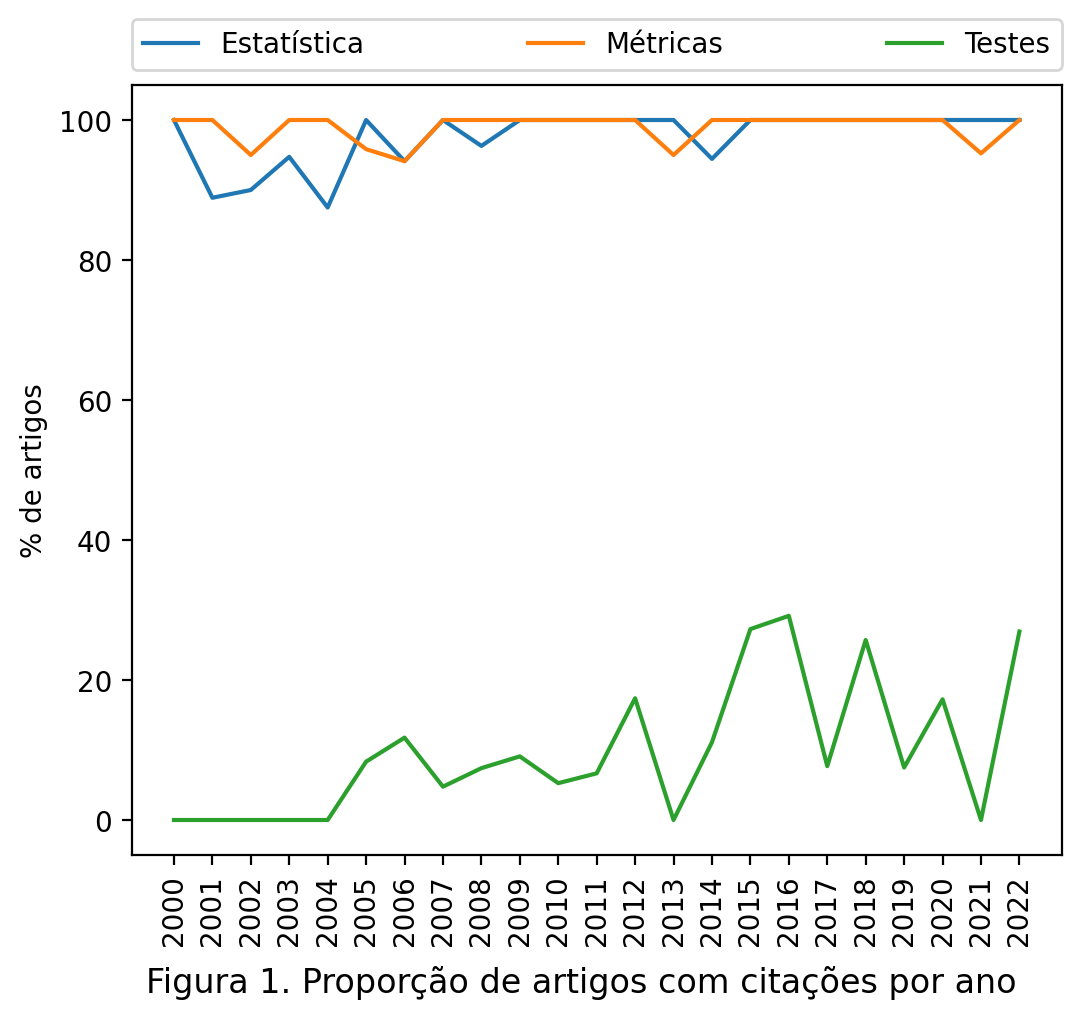

In [ ]:
fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.gca()
df_grafico_proporcao.fillna(0).mul(100).plot(
  ax = ax,
  ylabel='% de artigos',
  xticks=df_grafico_proporcao.index,
).set_xticklabels(
  df_grafico_proporcao.index,
  rotation='vertical'
)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.savefig(os.path.join(resultados_path, 'proporcao.svg'))
fig.suptitle(
  'Figura 1. Proporção de artigos com citações por ano',
  y=0.0
)
plt.show()

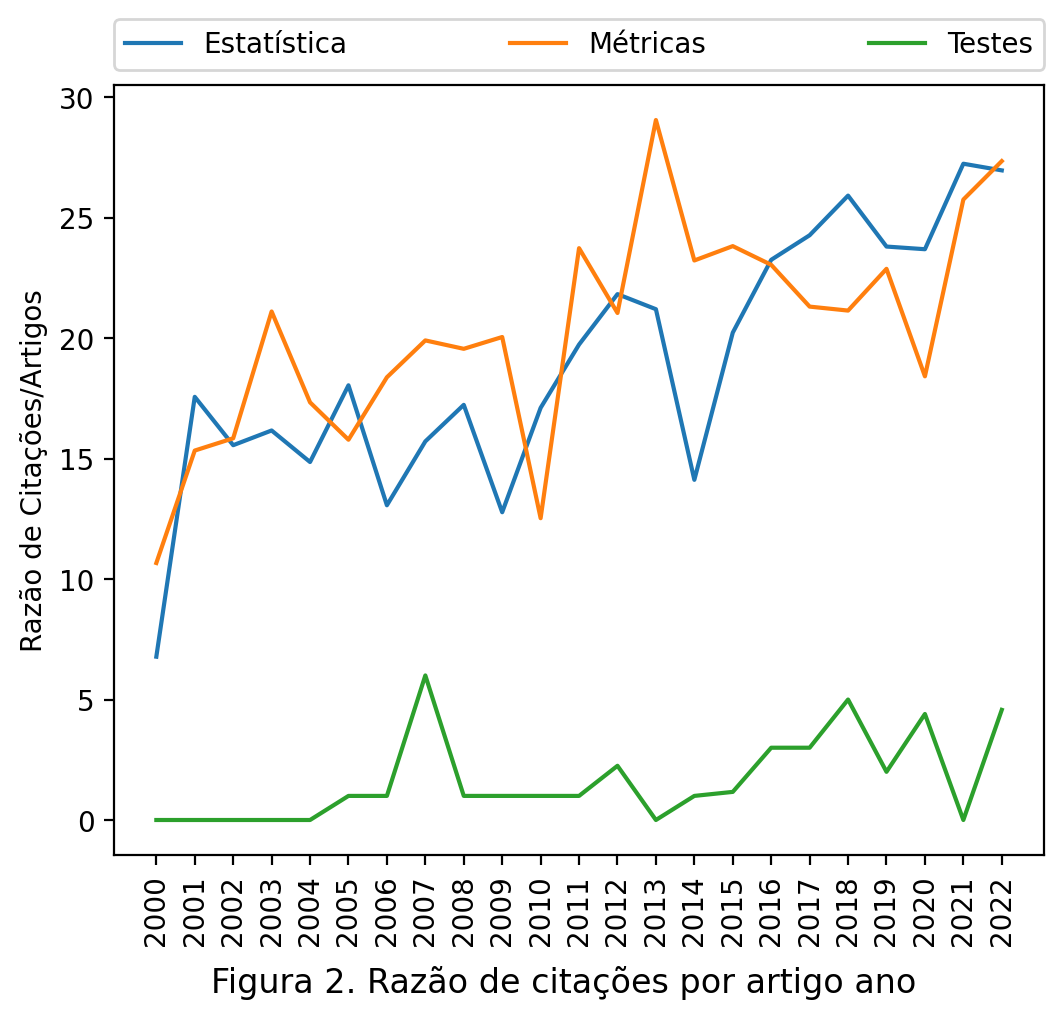

In [ ]:
fig = plt.figure(figsize=(6, 5), dpi=200)
ax = fig.gca()
df_grafico_razao.fillna(0).plot(
  ax = ax,
  ylabel='Razão de Citações/Artigos',
  xticks=df_grafico_razao.index
).set_xticklabels(
  df_grafico_razao.index,
  rotation='vertical'
)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=3)
plt.savefig(os.path.join(resultados_path, 'razao.svg'))
fig.suptitle(
  'Figura 2. Razão de citações por artigo ano',
  y=0.0
)
plt.show()

# ANOVA

In [ ]:
# Resultados dos testes
df_testes = pd.DataFrame(index=['Estatística','Métricas','Testes'])

In [ ]:
df_anova = citacoes[[
  (          'n',     ''),
  ('Estatística', 'art.'),
  (   'Métricas', 'art.'),
  (     'Testes', 'art.'),
]]\
.fillna(0)\
.droplevel(level=1, axis=1).reset_index()
df_anova.columns = ['ano', 'total', 'EST', 'MET', 'TST']

In [ ]:
# O artigo do Osório foi publicado em 2018, portanto, deveria repercurtir apenas a partir de 2019
df_anova['tratamento'] = np.where(df_anova['ano'].astype('int') < 2019, 'antes','depois')

In [ ]:
# Devido a diferença no número de trabalhos aceitos em cada ano, é necessário analisá-los percentualmente
for tipo in ['EST', 'MET', 'TST']:
  df_anova[tipo] = df_anova[tipo] / df_anova['total']

In [ ]:
df_anova

,ano,total,EST,MET,TST,tratamento
0,2000,9,1.000000,1.000000,0.000000,antes
1,2001,18,0.888889,1.000000,0.000000,antes
2,2002,20,0.900000,0.950000,0.000000,antes
3,2003,19,0.947368,1.000000,0.000000,antes
4,2004,24,0.875000,1.000000,0.000000,antes
5,2005,24,1.000000,0.958333,0.083333,antes
6,2006,17,0.941176,0.941176,0.117647,antes
7,2007,21,1.000000,1.000000,0.047619,antes
8,2008,27,0.962963,1.000000,0.074074,antes
9,2009,22,1.000000,1.000000,0.090909,antes


In [ ]:
csv_anova_path = os.path.join(resultados_path, 'anova.csv')
df_anova[['ano', 'total', 'MET', 'EST', 'TST', 'tratamento']].to_csv(
  csv_anova_path
  , sep=';'
  , header=True
  , index=False
  , compression=None
  , quoting=csv.QUOTE_NONNUMERIC
  , encoding='iso8859-1'
)

In [ ]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway
anova_fvalue, anova_pvalue = stats.f_oneway(
    df_anova[df_anova['tratamento'] == 'antes' ][['EST', 'MET', 'TST']],
    df_anova[df_anova['tratamento'] == 'depois'][['EST', 'MET', 'TST']],
)
print(list(zip(['EST', 'MET', 'TST'],anova_pvalue)))

[('EST', 0.208458496683851), ('MET', 0.9103758906361751), ('TST', 0.481997024087786)]


In [ ]:
df_testes['ANOVA'] = anova_pvalue

In [ ]:
# Residuals (experimental error) are approximately normally distributed
# (Shapiro-Wilk test or histogram)
# null hypothesis that the data was drawn from a normal distribution.

shapiro_wilk = []
for tipo in ['EST', 'MET', 'TST']:
  # Prevê o tratamento (var categórica) com base no n_art de um dado tipo
  formula = f'{tipo} ~ C(tratamento)'
  # https://www.statsmodels.org/dev/generated/statsmodels.formula.api.ols.html#statsmodels.formula.api.ols
  reg = smf.ols(formula, data=df_anova).fit()

  # verifica a normalidade dos resíduos
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro
  shapiro_test = stats.shapiro(
    reg.resid
  )
  print(f"{tipo}: p-value ={shapiro_test.pvalue:6.3f}")
  shapiro_wilk.append(shapiro_test.pvalue)

EST: p-value = 0.000
MET: p-value = 0.000
TST: p-value = 0.019


In [ ]:
df_testes['Shapiro-Wilk'] = shapiro_wilk

Como o p-valor para TST < alpha, os resíduos não são normalmente distribuídos, portanto o teste Mann-Whitney U pode ser mais apropriado para analisar as duas situações

In [ ]:
# homoscedasticity or Homogeneity of variances (variances are equal between treatment groups)
# Levene’s, Bartlett’s, or Brown-Forsythe test

# For samples from significantly non-normal populations, Levene’s test levene is more robust.
# null hypothesis that all input samples are from populations with equal variances
# p > alpha, aceita-se H0

levene = []
for tipo in ['EST', 'MET', 'TST']:
  antes  = df_anova[df_anova['tratamento'] == 'antes'  ][tipo]
  depois = df_anova[df_anova['tratamento'] == 'depois' ][tipo]
  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene
  _,levene_pvalue = stats.levene(antes, depois, center='median')
  print(f"{tipo}: p-value ={levene_pvalue:6.3f}")
  levene.append(levene_pvalue)

# Caso essa condição não seja válida, pode-se usar o teste Alexander Govern
# does not assume on homoscedasticity, instead relaxing the assumption of equal variances.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.alexandergovern.html#scipy.stats.alexandergovern

EST: p-value = 0.208
MET: p-value = 0.910
TST: p-value = 0.523


In [ ]:
df_testes['Levene'] = levene

In [ ]:
# Observations are sampled independently from each other (no relation in observations between the groups
# and within the groups) i.e., each subject should have only one response

# Aceita como satisfeita

In [ ]:
# The dependent variable should be continuous. If the dependent variable is ordinal or rank (e.g. Likert item data),
# it is more likely to violate the assumptions of normality and homogeneity of variances.
# If these assumptions are violated, you should consider the non-parametric tests
# (e.g. Mann-Whitney U test, Kruskal-Wallis test).

# Apesar a variável ser discreta, aceita como satisfeita

# Mann-Whitney U test (Wilcoxon rank sum test)

In [ ]:
# The observations from the two groups should be randomly selected from the target populations
# Observations are independent of each other
# Observations should be continuous or ordinal (e.g. Likert item data)

In [ ]:
# two-sided hypothesis in terms of median
# Null hypothesis: Two groups have equal median

teste_u = []
for tipo in ['EST', 'MET', 'TST']:
  antes  = df_anova[df_anova['tratamento'] == 'antes' ][tipo]
  depois = df_anova[df_anova['tratamento'] == 'depois'][tipo]

  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu
  mannwhitneyu_test = stats.mannwhitneyu(
    antes,
    depois,
    alternative = 'two-sided', # Defines the alternative hypothesis: the distributions are not equal, i.e. F(u) ≠ G(u) for at least one u.
    method="exact"
  )
  print(f"{tipo}: p-value ={mannwhitneyu_test.pvalue:6.3f}")
  teste_u.append(mannwhitneyu_test.pvalue)

EST: p-value = 0.286
MET: p-value = 1.000
TST: p-value = 0.611


In [ ]:
df_testes['Teste U'] = teste_u

In [ ]:
df_testes.index.name = 'Categoria'

In [ ]:
df_testes.style.\
  set_caption('P-valores dos testes realizados').\
  format(decimal=',', precision=3)

,ANOVA,Shapiro-Wilk,Levene,Teste U
Categoria,,,,
Estatística,"0,208","0,000","0,208","0,286"
Métricas,"0,910","0,000","0,910","1,000"
Testes,"0,482","0,019","0,523","0,611"


In [ ]:
df_testes.style.\
  set_caption('P-valores dos testes realizados').\
  format(decimal=',', precision=3).\
  to_latex(os.path.join(RESULTADOS_DIR, 'tabela_testes_hipoteses.tex'))

# Selecionar artigos para verificação manual

## Amostragem aleatória simples

In [ ]:
tamanho_amostra = 40
revisores = ('Gustavo', 'Rodrigo', 'Rogério', 'Thiago')
n_revisores = len(revisores)
artigos_por_revisor = tamanho_amostra // n_revisores
df_amostra = df_resultados.sample(
    n=tamanho_amostra,
    replace=False,
    random_state=42 # o sentido da vida, o universo e tudo mais
).reset_index().rename(columns={'index':'artigo'})

In [ ]:
df_amostra['revisor'] = sorted(revisores * artigos_por_revisor)

In [ ]:
colunas_amostra_head = ['revisor', 'ano', 'artigo']
colunas_amostra_tail = [c for c in list(df_amostra.columns.values) if c not in colunas_amostra_head]

In [ ]:
# ordernar df
df_amostra.sort_values(colunas_amostra_head, axis=0, inplace=True)

In [ ]:
df_amostra[colunas_amostra_head + colunas_amostra_tail]

,revisor,ano,artigo,PR,DIST,COR,VAR,HIST,MEAN,MODE,...,WSRT,ANOVA,ZTST,THSD,UTST,KWTST,HYPT,SL,CI,PVAL
2,Gustavo,2000,20687-73-16660-1-10-20220717.txt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gustavo,2005,18969-73-15196-2-10-20220302.txt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Gustavo,2005,18972-73-15199-2-10-20220302.txt,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3,Gustavo,2008,17677-73-14189-1-10-20211022.txt,0,0,1,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
8,Gustavo,2009,17400-73-13972-1-10-20211004.txt,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
7,Gustavo,2011,17269-73-13860-1-10-20210922.txt,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
0,Gustavo,2013,16784-73-13523-1-10-20210730.txt,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
6,Gustavo,2017,254-73-265-2003-2-20171017.txt,0,1,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
9,Gustavo,2021,18516-73-14907-1-10-20211220.txt,0,0,0,0,0,5,1,...,0,0,0,0,0,0,0,0,0,0
5,Gustavo,2022,21770.txt,0,0,0,0,7,2,0,...,0,0,0,0,0,0,0,0,0,0


### Copiar os artigos (pdf e txt) para revisão

In [ ]:
import shutil

amostra_path = os.path.join(resultados_path, 'amostra')
if not os.path.exists(amostra_path):
  os.makedirs(amostra_path, exist_ok=True)

for idx,row in df_amostra[colunas_amostra_head].iterrows():
  revisor = row['revisor']
  ano = row['ano']
  artigo_txt = row['artigo']
  artigo_pdf = f'{os.path.splitext(artigo_txt)[0]}.pdf'
  evento_dir = f'WSCAD{ano}'

  revisor_path = os.path.join(amostra_path, revisor)
  if not os.path.exists(revisor_path):
    os.mkdir(revisor_path)

  src_pdf = os.path.join(DADOS_PDF, evento_dir, artigo_pdf)
  src_txt = os.path.join(DADOS_TXT, evento_dir, pdf2txt_method_name(pdf2txt_tika), artigo_txt)
  dst_pdf = os.path.join(revisor_path, f'{evento_dir}__{artigo_pdf}')
  dst_txt = os.path.join(revisor_path, f'{evento_dir}__{artigo_txt}')

  shutil.copyfile(src_pdf, dst_pdf)
  shutil.copyfile(src_txt, dst_txt)

### CSV com os artigos a serem revisados

In [ ]:
csv_amostra_path = os.path.join(amostra_path, 'amostra.csv')
df_amostra[colunas_amostra_head + colunas_amostra_tail].to_csv(
  csv_amostra_path
  , sep=';'
  , header=True
  , index=False
  , compression=None
  , quoting=csv.QUOTE_NONNUMERIC
  , encoding='iso8859-1'
)

# Informações do ambiente
Lista informações do ambiente para fins de reprodutibilidade

In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.8.5
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.4.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.10
blosc2==2.0.0
bokeh==3.1.1
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.9
certifi==2023.7.22
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.6
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.1.0
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==3.4.8
cufflinks==0.17.3
cvxopt==1.3.1
cvxpy==1.3.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.36
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1